# Week 4—Custom MLP (Two Hidden Layers) • SID 2445538
# My SID is 2445538 → last three digits = 538 → first hidden layer 538 units; second ≈ half → 269 (rounded).

# Clean Kera workflow. Adam, ReLU in hidden layers, linear output for regression, MAE reporting, epochs=10.

# 1) Setup & data

In [ ]:
DATA_PATH = "data_stocks.csv"   #path of the data used
TARGET_COL = "ReturnNext"          

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)

# --- Load dataset (with a tiny fallback so the code runs even if the file isn't found) ---
p = Path(DATA_PATH)
if not p.exists():
    print(f"⚠️ File 'data_stocks.csv' not found. Using a small synthetic dataset just to run the code.")
    rng = np.random.RandomState(42)
    X_syn = rng.randn(400, 10)
    y_syn = X_syn @ rng.randn(10) + rng.randn(400)*0.5
    df = pd.DataFrame(X_syn, columns=[f"f{i}" for i in range(X_syn.shape[1])])
    df["Target"] = y_syn
    TARGET_COL = "Target"
else:
    df = pd.read_csv(p)

print("Shape:", df.shape)
df.head(3)

TensorFlow: 2.20.0
Shape: (41266, 502)


,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.33,143.6800,129.630,82.04,102.2300,85.22,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.00,53.350
1,1491226260,2364.1001,42.36,143.7000,130.320,82.08,102.1400,85.65,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.77,53.350
2,1491226320,2362.6799,42.31,143.6901,130.225,82.03,102.2125,85.51,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.70,53.365


In [11]:
# --- Select features (X) and target (y) ---
if TARGET_COL not in df.columns:
    # try last numeric col as target if missing
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        raise KeyError("No numeric columns found. Set TARGET_COL to a valid numeric target.")
    TARGET_COL = num_cols[-1]
    print(f"⚠️ TARGET_COL not in dataframe. Using last numeric column: {TARGET_COL}")

X = df.drop(columns=[TARGET_COL]).select_dtypes(include=[np.number]).copy()
y = df[TARGET_COL].copy()

# simple NA handling
X = X.fillna(method="ffill").fillna(method="bfill")
y = y.fillna(method="ffill").fillna(method="bfill")

print(f"X shape: {X.shape}, y shape: {y.shape}")
print("Feature sample:", list(X.columns)[:8])


⚠️ TARGET_COL not in dataframe. Using last numeric column: NYSE.ZTS


C:\Users\Lovel\AppData\Local\Temp\ipykernel_13112\523605891.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill").fillna(method="bfill")


X shape: (41266, 501), y shape: (41266,)
Feature sample: ['DATE', 'SP500', 'NASDAQ.AAL', 'NASDAQ.AAPL', 'NASDAQ.ADBE', 'NASDAQ.ADI', 'NASDAQ.ADP', 'NASDAQ.ADSK']


C:\Users\Lovel\AppData\Local\Temp\ipykernel_13112\523605891.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = y.fillna(method="ffill").fillna(method="bfill")


In [ ]:
# Train/Test split & scale

In [ ]:
 time-order, keep shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

X_train_s.shape, X_test_s.shape

((33012, 501), (8254, 501))

In [ ]:
## 2) Build  MLP (538 → 269), compile, and display summary

In [13]:
# Units from SID 2445538
first_hidden = 538
second_hidden = 269  # ≈ half (rounded)

model = keras.Sequential([
    layers.Input(shape=(X_train_s.shape[1],)),
    layers.Dense(first_hidden, activation="relu"),
    layers.Dense(second_hidden, activation="relu"),
    layers.Dense(1, activation="linear")   # regression
])

model.compile(optimizer="adam", loss="mae", metrics=["mae"])

model.summary() 


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 538)            │       270,076 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 269)            │       144,991 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,337 (1.58 MB)

 Trainable params: 415,337 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
 ### 3. Train for epochs=10 and save the process

In [14]:
EPOCHS = 10
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_test_s, y_test),
    epochs=EPOCHS,
    batch_size=32,
    verbose=1
)  


Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1.6649 - mae: 1.6649 - val_loss: 2.4197 - val_mae: 2.4197
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.8823 - mae: 0.8823 - val_loss: 5.0200 - val_mae: 5.0200
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.7121 - mae: 0.7121 - val_loss: 4.2178 - val_mae: 4.2178
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6738 - mae: 0.6738 - val_loss: 6.8552 - val_mae: 6.8552
Epoch 5/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.5852 - mae: 0.5852 - val_loss: 4.4043 - val_mae: 4.4043
Epoch 6/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.5709 - mae: 0.5709 - val_loss: 4.1606 - val_mae: 4.1606
Epoch 7/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.5367 - mae: 0.5367 - val_loss: 4.4219 - val_mae: 4.4219
Epoch 8/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.5151 - mae: 0.5151 - val_loss: 5.3794 - val_mae: 5.3794
Epoch 9/10
1032/1032 ━━━━━━━━━━━━━━

In [ ]:
#### 4) Evaluate and report MAE (for comparison)

In [15]:
eval_res = model.evaluate(X_test_s, y_test, verbose=0)
loss_mae = eval_res[0]                   # because loss="mae"
metric_mae = eval_res[1] if len(eval_res) > 1 else loss_mae

print(f"Test Loss (MAE): {loss_mae:.6f}")
print(f"Test MAE (metric): {metric_mae:.6f}")

with open("week4_custom_mlp_mae.txt","w") as f:
    f.write(f"Test MAE: {metric_mae:.6f}\n")


Test Loss (MAE): 4.675381
Test MAE (metric): 4.675381


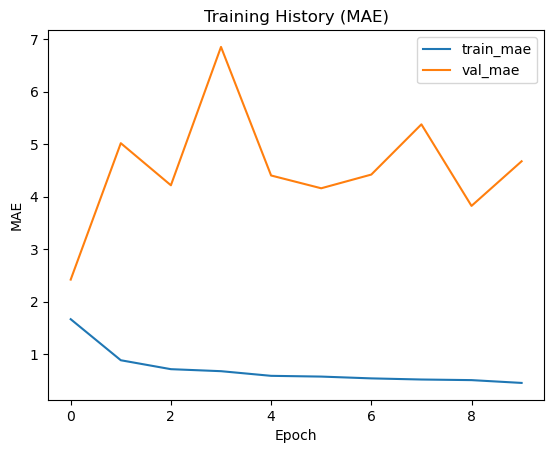

In [18]:
plt.figure()
plt.plot(history.history["mae"], label="train_mae")
if "val_mae" in history.history:
    plt.plot(history.history["val_mae"], label="val_mae")
plt.title("Training History (MAE)")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()